[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lowry777/3253-Project_Group-18/blob/main/Group18_3253_Project-Toronto_Shelter_Occupancy.ipynb)

## **Toronto Daily Shelter Occupancy Overview**

The data set provides a listing of all the active shelters serving the City of Toronto area. Included in the dataset is the name of the shelter, program name, sector served (i.e. men, women, youth, families) addresses, program capacity, and the number of people that occupied those spaces at 4:00 AM the next morning.

Data limitations:
- Data entry errors such as address, capacity blank and occupancy blank or 0
- Facilty address not provided

# Import Standard Librairies

In [1]:
#Import standard librairies
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import uniform
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, precision_recall_curve, roc_auc_score, roc_curve, recall_score
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV, TimeSeriesSplit, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC


#from google.colab import drive
#drive.mount('/content/gdrive')

# Load and Clean Data

In [2]:
#load data from online csv details: https://open.toronto.ca/dataset/daily-shelter-occupancy/
csvs = ["https://ckan0.cf.opendata.inter.prod-toronto.ca/datastore/dump/23efca84-00ff-4738-afbb-1cd6fa9cf5dc","https://ckan0.cf.opendata.inter.prod-toronto.ca/datastore/dump/f44e3cef-5663-436a-838f-f444dd1d0c92", "https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/8a6eceb2-821b-4961-a29d-758f3087732d/resource/c8bc0bf8-5cef-48e7-9606-7277f8efd6d6/download/smis_daily_occupancy_2019.csv"] #2017, 2018, 2019
merged = []
year = 2017

for c in csvs:
  read = pd.read_csv(c)
  read["file_year"] = year
  year = year + 1
  merged.append(read)

df_orig = pd.concat(merged)
df_orig

,_id,OCCUPANCY_DATE,ORGANIZATION_NAME,SHELTER_NAME,SHELTER_ADDRESS,SHELTER_CITY,SHELTER_PROVINCE,SHELTER_POSTAL_CODE,FACILITY_NAME,PROGRAM_NAME,SECTOR,OCCUPANCY,CAPACITY,file_year
0,1.0,2017-01-01T00:00:00,COSTI Immigrant Services,COSTI Reception Centre,100 Lippincott Street,Toronto,ON,M5S 2P1,COSTI Reception Centre,COSTI Reception Ctr CITY Program,Co-ed,16,16.0,2017
1,2.0,2017-01-01T00:00:00,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Extreme Weather Program,Men,13,17.0,2017
2,3.0,2017-01-01T00:00:00,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Men's Hostel,Men,63,63.0,2017
3,4.0,2017-01-01T00:00:00,"Christie Refugee Welcome Centre, Inc.",Christie Refugee Welcome Centre,43 Christie Street,Toronto,ON,M6G 3B1,Christie Refugee Welcome Centre,Christie Refugee Welcome Ctr - Settlement and ...,Families,66,70.0,2017
4,5.0,2017-01-01T00:00:00,City of Toronto,Birchmount Residence,1673 Kingston Road,Toronto,ON,NaN,Birchmount Res 1673 Kingston Rd,Birchmount Residence,Men,58,60.0,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39441,NaN,12/31/2019,YWCA Toronto,YWCA-348 Davenport,348 Davenport Rd.,Toronto,ON,M5R 1K6,YWCA - 348 Davenport Road Youth,YWCA Davenport - Youth,Youth,15,15.0,2019
39442,NaN,12/31/2019,Youth Without Shelter,Youth Without Shelter,6 Warrendale Court,Etobicoke,ON,M9V 1P9,Youth w/o Shelter Emerg Shelter,Youth without Shelter Emergency Shelter Program,Youth,33,33.0,2019
39443,NaN,12/31/2019,Youth Without Shelter,Youth Without Shelter,6 Warrendale Court,Etobicoke,ON,M9V 1P9,Youth w/o Shltr Transitional Res,Youth without Shelter Stay In School Program,Youth,20,20.0,2019
39444,NaN,12/31/2019,YouthLink,YouthLink Shelter,747 Warden Ave,Toronto,ON,M1L 4A1,YouthLink - 747 Warden Ave,YouthLink Emergency Program,Co-ed,9,10.0,2019


In [3]:
#rename headers to simpler and lower case names
df = df_orig.rename(columns={'_id': 'id','OCCUPANCY_DATE':'date','ORGANIZATION_NAME':'organization','SHELTER_NAME':'shelter','SHELTER_ADDRESS':'address','SHELTER_CITY':'city','SHELTER_PROVINCE':'prov','SHELTER_POSTAL_CODE':'postcode','FACILITY_NAME':'facility','PROGRAM_NAME':'program','SECTOR':'sector'}).drop(['id','file_year'], axis=1)
df.columns = map(str.lower, df.columns)
df['shelter'] = df.shelter.replace({'Kennedy House Youth shelter': 'Kennedy House Youth Shelter'}) #clean lower case shelter to avoid unncessary splitting from records with upper case Shelter
df['program'] = df.program.replace({'CLOSED University Settlement - Out of the Cold': 'University Settlement - Out of the Cold'}) #removed CLOSED to avoid unncessary splitting from records without closed
df.head()

,date,organization,shelter,address,city,prov,postcode,facility,program,sector,occupancy,capacity
0,2017-01-01T00:00:00,COSTI Immigrant Services,COSTI Reception Centre,100 Lippincott Street,Toronto,ON,M5S 2P1,COSTI Reception Centre,COSTI Reception Ctr CITY Program,Co-ed,16,16.0
1,2017-01-01T00:00:00,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Extreme Weather Program,Men,13,17.0
2,2017-01-01T00:00:00,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Men's Hostel,Men,63,63.0
3,2017-01-01T00:00:00,"Christie Refugee Welcome Centre, Inc.",Christie Refugee Welcome Centre,43 Christie Street,Toronto,ON,M6G 3B1,Christie Refugee Welcome Centre,Christie Refugee Welcome Ctr - Settlement and ...,Families,66,70.0
4,2017-01-01T00:00:00,City of Toronto,Birchmount Residence,1673 Kingston Road,Toronto,ON,NaN,Birchmount Res 1673 Kingston Rd,Birchmount Residence,Men,58,60.0


In [4]:
#Engineer date into component parts
df['date'] = pd.to_datetime(df.date)
df['month'] = pd.DatetimeIndex(df['date']).month
df['year'] = pd.DatetimeIndex(df['date']).year
df['day'] = pd.DatetimeIndex(df['date']).day
df['weekday'] = pd.DatetimeIndex(df['date']).weekday #Note Monday = 0, Sunday = 6
# To consider: Add a day/year (Dec-31) to account for holidays or factors unique to specific day of year?
df.head()

,date,organization,shelter,address,city,prov,postcode,facility,program,sector,occupancy,capacity,month,year,day,weekday
0,2017-01-01,COSTI Immigrant Services,COSTI Reception Centre,100 Lippincott Street,Toronto,ON,M5S 2P1,COSTI Reception Centre,COSTI Reception Ctr CITY Program,Co-ed,16,16.0,1,2017,1,6
1,2017-01-01,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Extreme Weather Program,Men,13,17.0,1,2017,1,6
2,2017-01-01,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Men's Hostel,Men,63,63.0,1,2017,1,6
3,2017-01-01,"Christie Refugee Welcome Centre, Inc.",Christie Refugee Welcome Centre,43 Christie Street,Toronto,ON,M6G 3B1,Christie Refugee Welcome Centre,Christie Refugee Welcome Ctr - Settlement and ...,Families,66,70.0,1,2017,1,6
4,2017-01-01,City of Toronto,Birchmount Residence,1673 Kingston Road,Toronto,ON,NaN,Birchmount Res 1673 Kingston Rd,Birchmount Residence,Men,58,60.0,1,2017,1,6


In [5]:
import fileinput
#weather data downloaded as per https://climate.weather.gc.ca/historical_data/search_historic_data_e.html using Cygwin64 Terminal for Toronto Intl A weather station 
#filePath ="/content/gdrive/My Drive/Colab Notebooks/U of T/3253/Project/en_climate_daily_toronto_intl_A_2017_2019.csv"
#weather_orig = pd.read_csv(filePath, sep=",")

url = 'https://raw.githubusercontent.com/lowry777/3253-Project_Group-18/main/en_climate_daily_toronto_intl_A_2017_2019.csv'
weather_orig = pd.read_csv(url)

weather = weather_orig[['Date/Time','Max Temp (°C)','Min Temp (°C)','Total Rain (mm)', 'Total Snow (cm)','Snow on Grnd (cm)','Spd of Max Gust (km/h)']].copy()
weather.rename(columns={'Date/Time': 'date','Max Temp (°C)':'max_temp','Min Temp (°C)':'min_temp','Total Rain (mm)':'rain','Total Snow (cm)':'snow','Snow on Grnd (cm)': 'snow_ground', 'Spd of Max Gust (km/h)': 'max_gust'},inplace=True)
weather['date'] = pd.to_datetime(weather.date)
#weather = weather.query('20170101 <= date <= 20191231')
df = pd.merge(df, weather, on ='date', how ='left')
df['max_gust'] = df.max_gust.replace({'<31': 30}).astype(float) #replace <31 flag string with 30 for numerical calculations
df.snow_ground.fillna(value=0, inplace=True) #many blanks, assume blanks are no snow on ground based on no missing flag in source
df.head()

,date,organization,shelter,address,city,prov,postcode,facility,program,sector,occupancy,capacity,month,year,day,weekday,max_temp,min_temp,rain,snow,snow_ground,max_gust
0,2017-01-01,COSTI Immigrant Services,COSTI Reception Centre,100 Lippincott Street,Toronto,ON,M5S 2P1,COSTI Reception Centre,COSTI Reception Ctr CITY Program,Co-ed,16,16.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0
1,2017-01-01,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Extreme Weather Program,Men,13,17.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0
2,2017-01-01,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Men's Hostel,Men,63,63.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0
3,2017-01-01,"Christie Refugee Welcome Centre, Inc.",Christie Refugee Welcome Centre,43 Christie Street,Toronto,ON,M6G 3B1,Christie Refugee Welcome Centre,Christie Refugee Welcome Ctr - Settlement and ...,Families,66,70.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0
4,2017-01-01,City of Toronto,Birchmount Residence,1673 Kingston Road,Toronto,ON,NaN,Birchmount Res 1673 Kingston Rd,Birchmount Residence,Men,58,60.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0


In [6]:
df.info()
#df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115916 entries, 0 to 115915
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          115916 non-null  datetime64[ns]
 1   organization  115916 non-null  object        
 2   shelter       115916 non-null  object        
 3   address       115916 non-null  object        
 4   city          115916 non-null  object        
 5   prov          115916 non-null  object        
 6   postcode      110422 non-null  object        
 7   facility      115916 non-null  object        
 8   program       115916 non-null  object        
 9   sector        115916 non-null  object        
 10  occupancy     115916 non-null  int64         
 11  capacity      115573 non-null  float64       
 12  month         115916 non-null  int64         
 13  year          115916 non-null  int64         
 14  day           115916 non-null  int64         
 15  weekday       115

In [7]:
#Join in lat/long 

#Confirmed 1 address per shelter
#pd.set_option('display.max_rows', 100) #shows 100 rows
#pd.reset_option('display.max_rows') #resets back to normal output
#unique_shelter = df.groupby('shelter')['address'].agg(['first','count','nunique']).reset_index(drop=False)
#unique_shelter['count'].sum() == unique_shelter['shelter'].count()

#Unique shelters for geocoding locations - Only ran once to generate csv to avoid triggering geocoding limits

#from geopy.geocoders import Nominatim
#geolocator = Nominatim(user_agent="ML School Project Group 18")

#shelter_loc = df[['shelter','address','city','prov','postcode']].drop_duplicates(subset = ['shelter']) #get unique list of shelter and location info
#shelter_loc['address'] = shelter_loc.address.replace({'Bathrust': 'Bathurst', ', 2nd floor': ''}, regex=True) #Correct errors in source data to allow match, regex=True allows for instring search
#shelter_loc['full_address'] = shelter_loc.address + ',' + shelter_loc.city + ',' + shelter_loc.prov + ',' #concat to pass to geocode search, note postcal code didn't work well so removed
#shelter_loc['gcode'] = shelter_loc.full_address.apply(geolocator.geocode) #returns full geocode
#shelter_loc['lat'] = [g.latitude for g in shelter_loc.gcode] #extract lat from geocode
#shelter_loc['long'] = [g.longitude for g in shelter_loc.gcode] #extract long from geocode

#from google.colab import files
#shelter_loc.to_csv('shelter_loc.csv', index=False)
#files.download('shelter_loc.csv')


#Note for future geocode can try set up as dictionary for improved search such as:
#location = geolocator.geocode({'street': '100 Lippincott Street', 'city': 'Toronto', 'state': 'Ontario', 'country': 'Canada'})
#print(location.address)
#print((location.latitude, location.longitude))

#filePath ="/content/gdrive/My Drive/Colab Notebooks/U of T/3253/Project/shelter_loc.csv"
#shelter_loc = pd.read_csv(filePath, sep=",")

url = 'https://raw.githubusercontent.com/lowry777/3253-Project_Group-18/main/shelter_loc.csv'
shelter_loc = pd.read_csv(url)

df = pd.merge(df, shelter_loc[['shelter','lat', 'long']], on ='shelter', how ='left') 
df.head()

,date,organization,shelter,address,city,prov,postcode,facility,program,sector,occupancy,capacity,month,year,day,weekday,max_temp,min_temp,rain,snow,snow_ground,max_gust,lat,long
0,2017-01-01,COSTI Immigrant Services,COSTI Reception Centre,100 Lippincott Street,Toronto,ON,M5S 2P1,COSTI Reception Centre,COSTI Reception Ctr CITY Program,Co-ed,16,16.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0,43.657927,-79.407106
1,2017-01-01,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Extreme Weather Program,Men,13,17.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0,43.665860,-79.445919
2,2017-01-01,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Men's Hostel,Men,63,63.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0,43.665860,-79.445919
3,2017-01-01,"Christie Refugee Welcome Centre, Inc.",Christie Refugee Welcome Centre,43 Christie Street,Toronto,ON,M6G 3B1,Christie Refugee Welcome Centre,Christie Refugee Welcome Ctr - Settlement and ...,Families,66,70.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0,43.665172,-79.418864
4,2017-01-01,City of Toronto,Birchmount Residence,1673 Kingston Road,Toronto,ON,NaN,Birchmount Res 1673 Kingston Rd,Birchmount Residence,Men,58,60.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0,43.691590,-79.264226


In [8]:
#Create percent occupied (occ_perc) and full (1, 0)
df['occ_perc'] = df.occupancy / df.capacity
df['full'] = df['occ_perc'].apply(lambda x: 1 if x >= 1 else 0) #Full if occupancy is greater or equal to
df.head()

,date,organization,shelter,address,city,prov,postcode,facility,program,sector,occupancy,capacity,month,year,day,weekday,max_temp,min_temp,rain,snow,snow_ground,max_gust,lat,long,occ_perc,full
0,2017-01-01,COSTI Immigrant Services,COSTI Reception Centre,100 Lippincott Street,Toronto,ON,M5S 2P1,COSTI Reception Centre,COSTI Reception Ctr CITY Program,Co-ed,16,16.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0,43.657927,-79.407106,1.000000,1
1,2017-01-01,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Extreme Weather Program,Men,13,17.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0,43.665860,-79.445919,0.764706,0
2,2017-01-01,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Men's Hostel,Men,63,63.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0,43.665860,-79.445919,1.000000,1
3,2017-01-01,"Christie Refugee Welcome Centre, Inc.",Christie Refugee Welcome Centre,43 Christie Street,Toronto,ON,M6G 3B1,Christie Refugee Welcome Centre,Christie Refugee Welcome Ctr - Settlement and ...,Families,66,70.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0,43.665172,-79.418864,0.942857,0
4,2017-01-01,City of Toronto,Birchmount Residence,1673 Kingston Road,Toronto,ON,NaN,Birchmount Res 1673 Kingston Rd,Birchmount Residence,Men,58,60.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0,43.691590,-79.264226,0.966667,0


In [9]:
#Check data
#df.describe() # occ_perc needs to be cleaned
df.info() # nulls for postcode, capacity and occ_perc. Clean capacity

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115916 entries, 0 to 115915
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          115916 non-null  datetime64[ns]
 1   organization  115916 non-null  object        
 2   shelter       115916 non-null  object        
 3   address       115916 non-null  object        
 4   city          115916 non-null  object        
 5   prov          115916 non-null  object        
 6   postcode      110422 non-null  object        
 7   facility      115916 non-null  object        
 8   program       115916 non-null  object        
 9   sector        115916 non-null  object        
 10  occupancy     115916 non-null  int64         
 11  capacity      115573 non-null  float64       
 12  month         115916 non-null  int64         
 13  year          115916 non-null  int64         
 14  day           115916 non-null  int64         
 15  weekday       115

In [10]:
#check nulls for occ_perc
#filtered_df = df[df['occ_perc'].isnull()]
#filtered_df
#Many 0s for capacity and some for occupancy...assume some true and some errors. Remove records where capacity is null or 0. Some cases where 0 occupancy might be input errors 

In [11]:
#Remove capacity = 0, occupancy also often 0, likely missing values
df.dropna(subset=['capacity'],inplace = True)
df = df[df.capacity!=0]
#df

In [12]:
df = df.sort_values(by=['program','date'], ascending=[True, True])
df['prior_day_occ_perc'] = df['occ_perc'].shift() #Not an ideal solution, doesn't capture if same program or is actually prior day but good enough for now
df.prior_day_occ_perc.fillna(df.prior_day_occ_perc.bfill(), inplace=True)# Should happen after train test split since leaking in somee infor 
#df[:100]

#for i in range(len(df)):
#    if df.loc[i,"program"] == df.loc[i-1,"program"] and df.loc[i,"date"] == df.loc[i-1,"date"] + pd.DateOffset(-1)
#        df.loc[i,"prior_day_occ_perc"] = df.loc[i-1,"occ_perc"]
#    else:
#        None

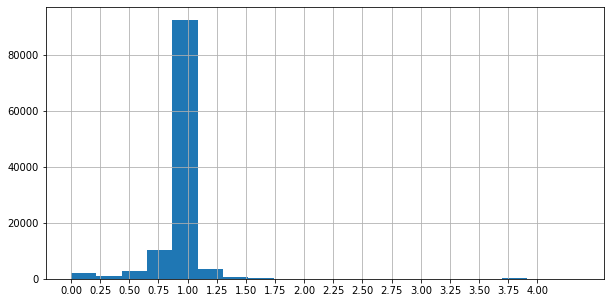

In [13]:
ax = df.occ_perc.hist(bins=20, figsize=(10,5))
ax = plt.xticks(np.linspace(0,4,17))

In [14]:
#Drop outliers
filtered = df[df['occ_perc'] > 1.4].groupby('program')['program'].agg(['count']) 

filtered = df.set_index(['program']).occ_perc.rename('>=1.4').ge(1.4)  \
  .groupby(level=[0]).value_counts(True).unstack(fill_value=0)

filtered.loc[['Family Residence - Main','Family Residence - TO site (Internal Referral Only)']] 

df = df[df.occ_perc < 1.4]

In [15]:
#pd.set_option('display.max_rows', 200) #shows 100 rows
#pd.reset_option('display.max_rows') #resets back to normal output
#unique_facility = df.groupby(['shelter','facility'])['facility'].agg(['count'])
#unique_facility
#most shelters have multiple facilities, seem to be at different addresses. Maybe remove shelter?

In [16]:
#unique_program = df.groupby(['program','facility'])['program'].agg(['count'])
#unique_program
#most programs are unique to facility maybe only need program?

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112206 entries, 111136 to 115915
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date                112206 non-null  datetime64[ns]
 1   organization        112206 non-null  object        
 2   shelter             112206 non-null  object        
 3   address             112206 non-null  object        
 4   city                112206 non-null  object        
 5   prov                112206 non-null  object        
 6   postcode            106712 non-null  object        
 7   facility            112206 non-null  object        
 8   program             112206 non-null  object        
 9   sector              112206 non-null  object        
 10  occupancy           112206 non-null  int64         
 11  capacity            112206 non-null  float64       
 12  month               112206 non-null  int64         
 13  year                1122

In [18]:
df.sort_values(by='date', ascending=True, inplace=True)
df_ml = df.drop(['date','address','city','occupancy','prov','postcode','rain','snow','lat','long','organization','shelter','facility'], axis=1)#.replace([np.inf, -np.inf], np.nan).dropna()
df_ml

,program,sector,capacity,month,year,day,weekday,max_temp,min_temp,snow_ground,max_gust,occ_perc,full,prior_day_occ_perc
64,Native Child & Family Services Toronto,Youth,12.0,1,2017,1,6,1.8,-2.5,3.0,50.0,0.916667,0,1.000000
60,Kennedy House Youth Shelter: Bedded Program,Youth,33.0,1,2017,1,6,1.8,-2.5,3.0,50.0,1.000000,1,0.938462
14,Family Residence - Main,Families,110.0,1,2017,1,6,1.8,-2.5,3.0,50.0,1.345455,1,1.125000
58,Homes First Society - Strachan House,Co-ed,83.0,1,2017,1,6,1.8,-2.5,3.0,50.0,0.987952,0,1.000000
81,Salvation Army - Florence Booth Womens Ministry,Women,60.0,1,2017,1,6,1.8,-2.5,3.0,50.0,1.000000,1,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115911,YWCA Davenport - Youth,Youth,15.0,12,2019,31,1,2.3,-1.5,1.0,54.0,1.000000,1,1.000000
115887,S.A. Evangeline - Emergency Weather,Women,9.0,12,2019,31,1,2.3,-1.5,1.0,54.0,1.000000,1,1.000000
115822,Robertson House - MAIN Program,Families,90.0,12,2019,31,1,2.3,-1.5,1.0,54.0,1.222222,1,1.244444
115813,Downsview Dells Bedded Program,Men,28.0,12,2019,31,1,2.3,-1.5,1.0,54.0,0.821429,0,0.928571


# Exploratory Data Analysis

In [ ]:
# occupancy %, percent full, capacity by shelter, visualization on map, cut by program where possible, correlation 

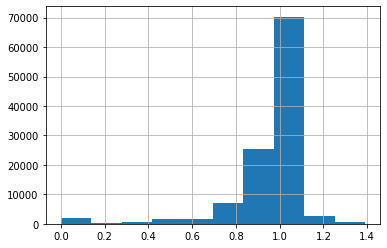

In [ ]:
df.occ_perc.hist()
#Outliers removed earlier, note often at or very near capacity

In [ ]:
df.full.mean()

0.565789708215247

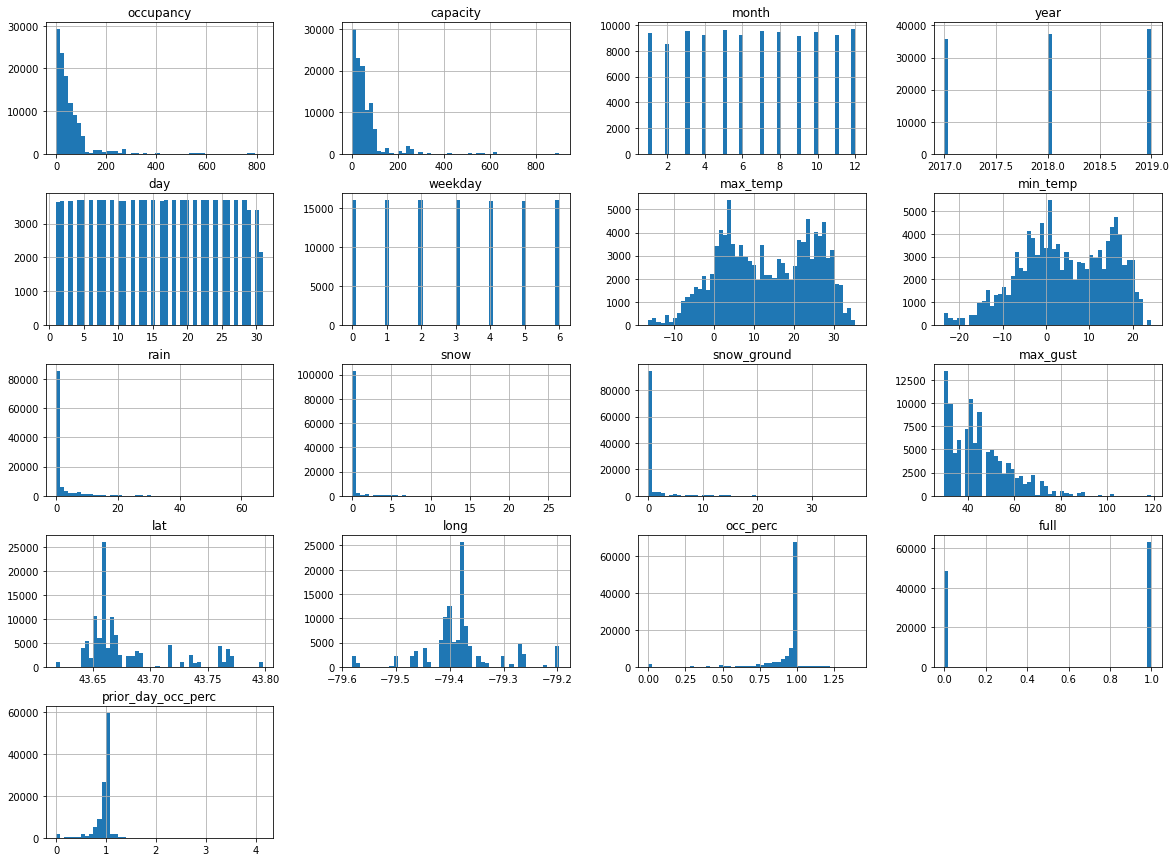

In [ ]:
df.hist(bins=50, figsize=(20,15))
plt.show()

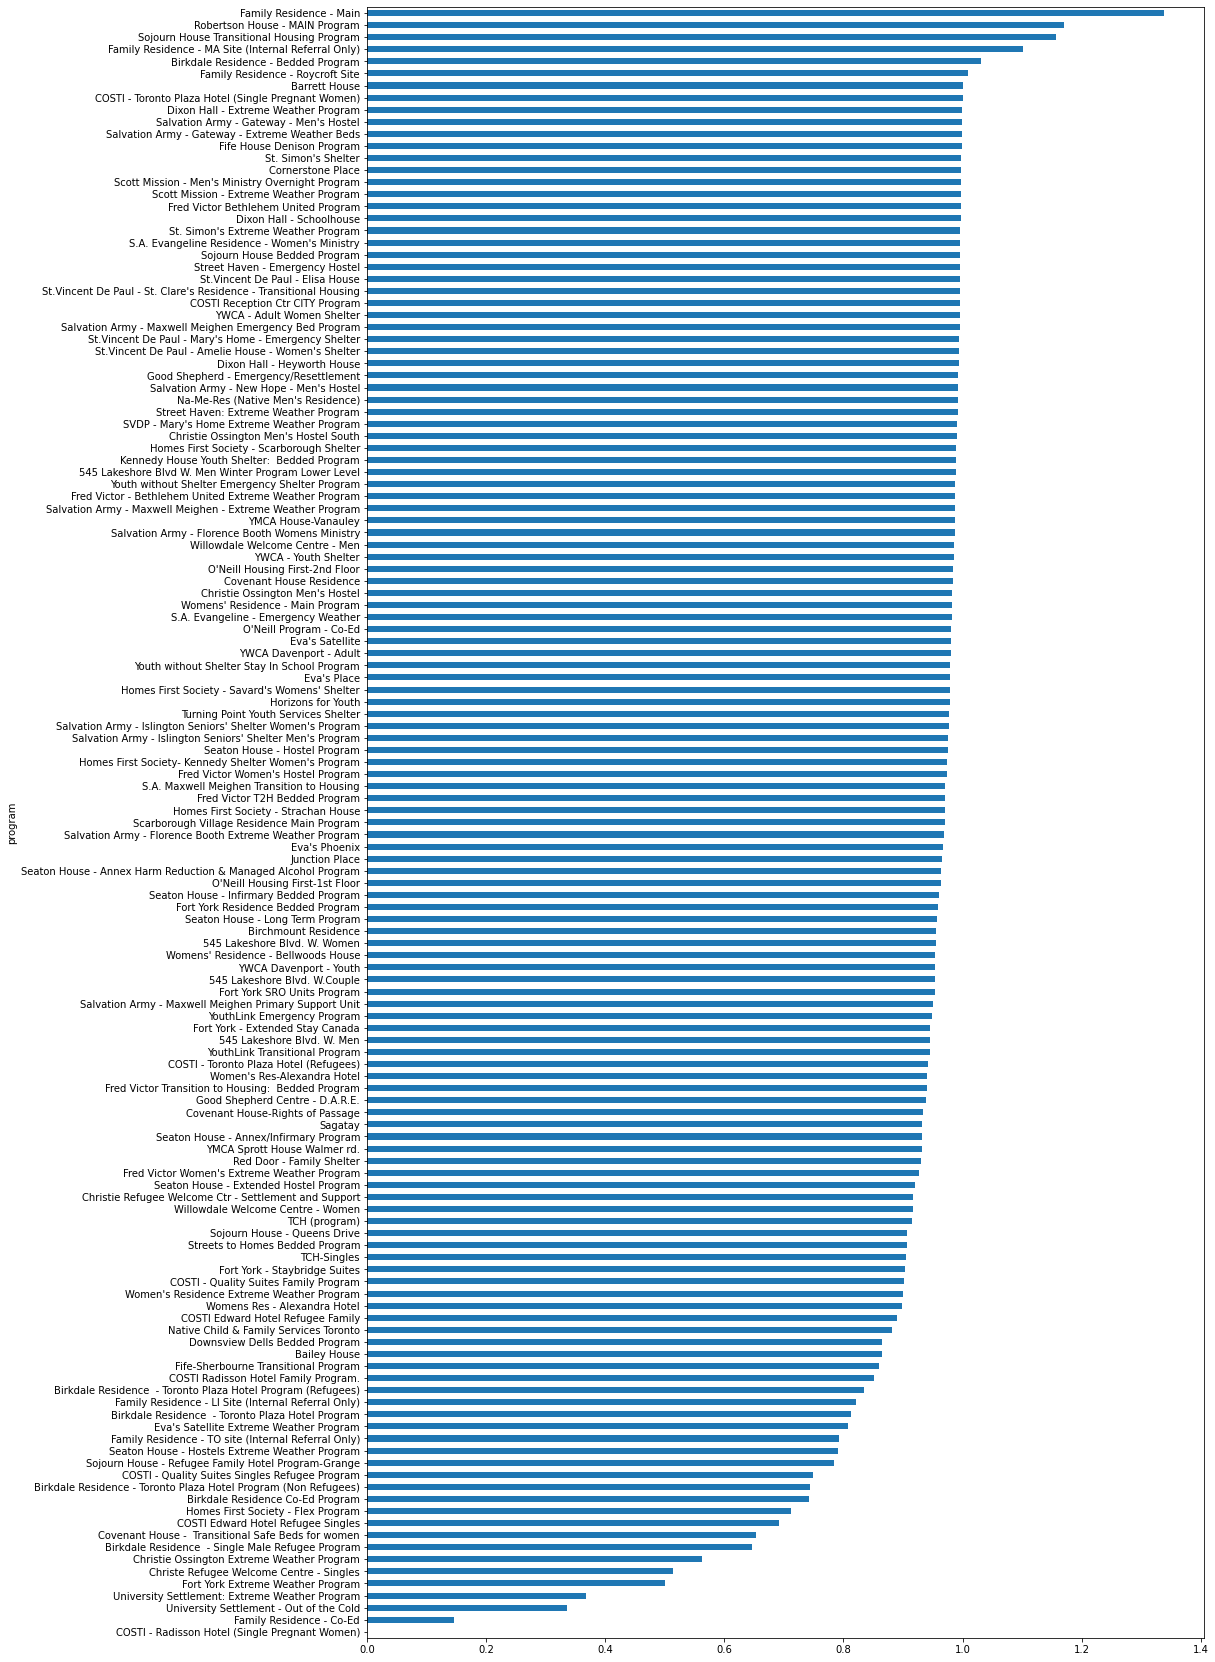

In [ ]:
df.groupby('program').occ_perc.mean().sort_values(ascending=True).plot.barh(figsize=(15,30))

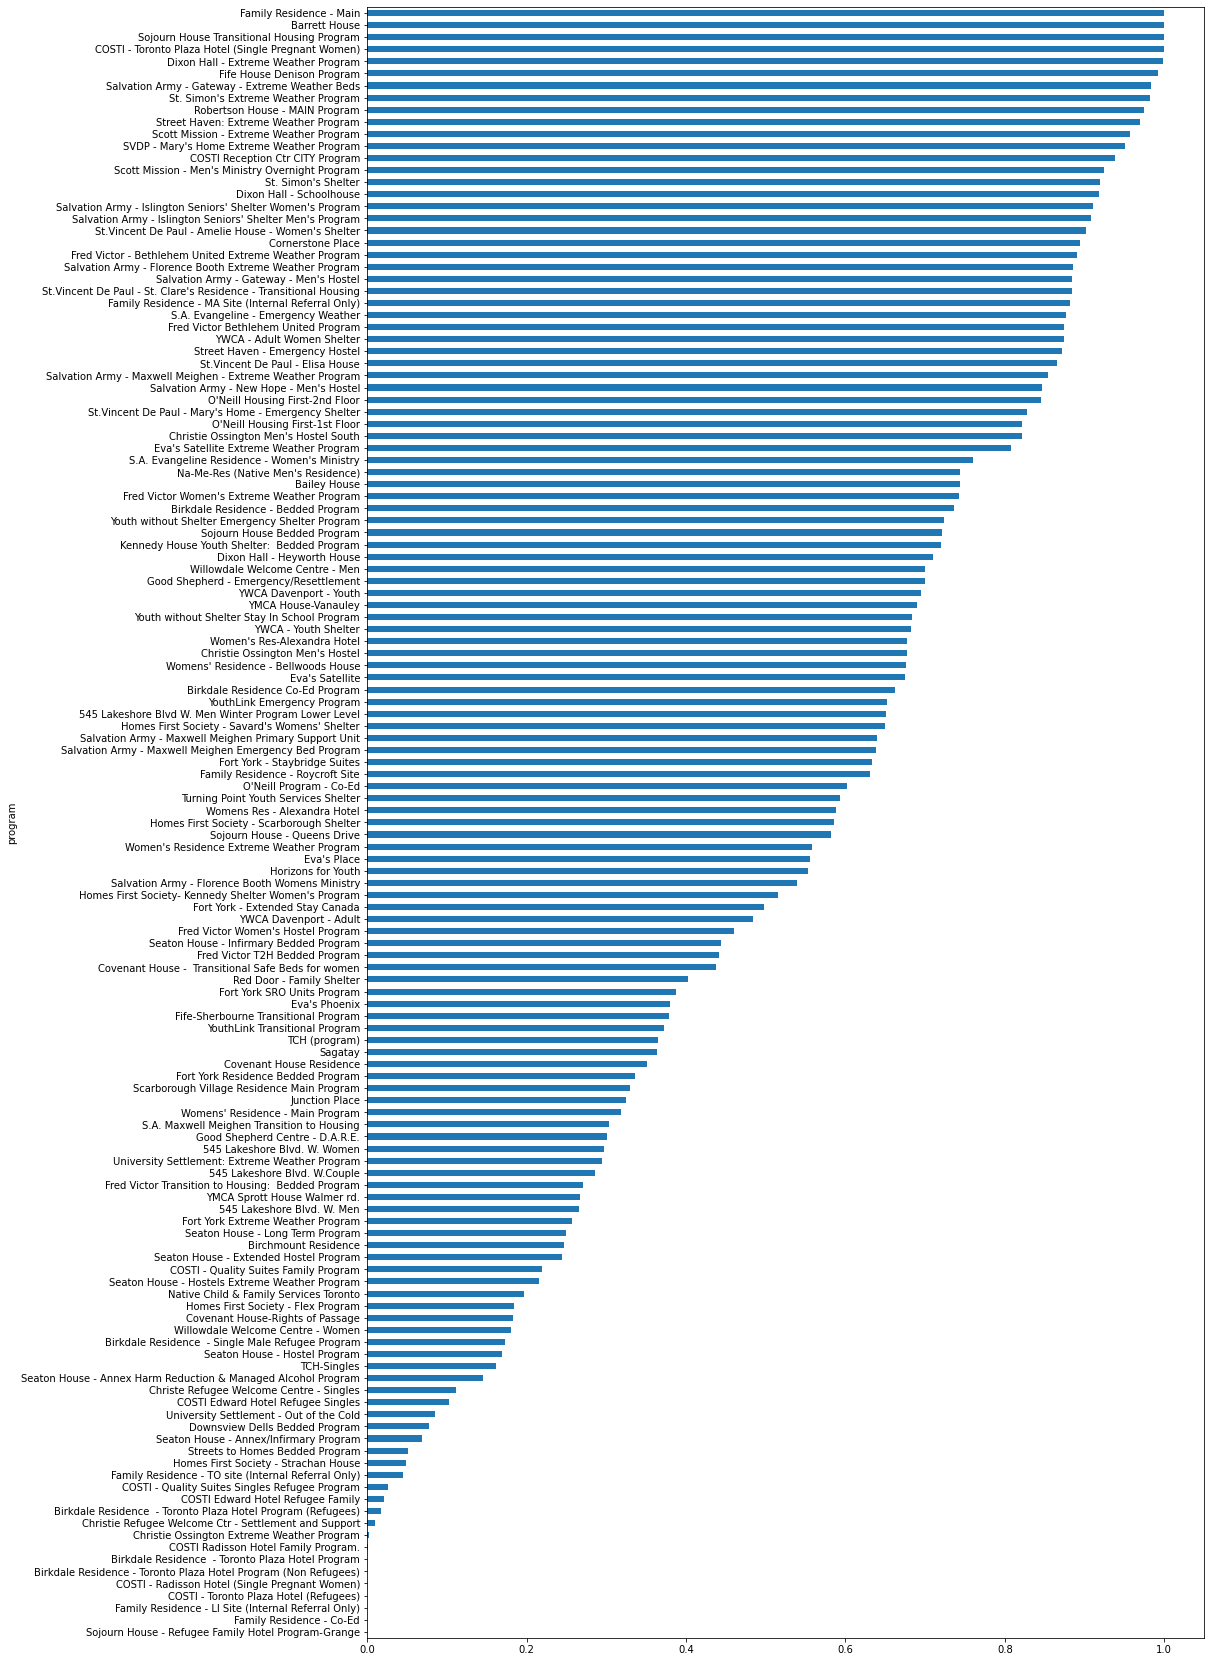

In [ ]:
df.groupby('program').full.mean().sort_values(ascending=True).plot.barh(figsize=(15,30))

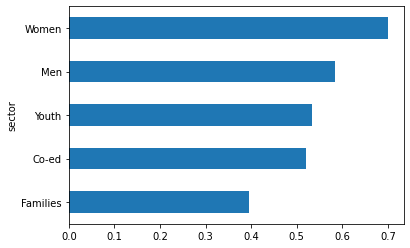

In [ ]:
df.groupby('sector').full.mean().sort_values(ascending=True).plot.barh()

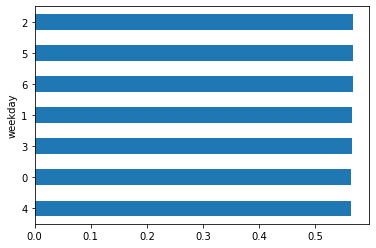

In [ ]:
df.groupby('weekday').full.mean().sort_values(ascending=True).plot.barh()

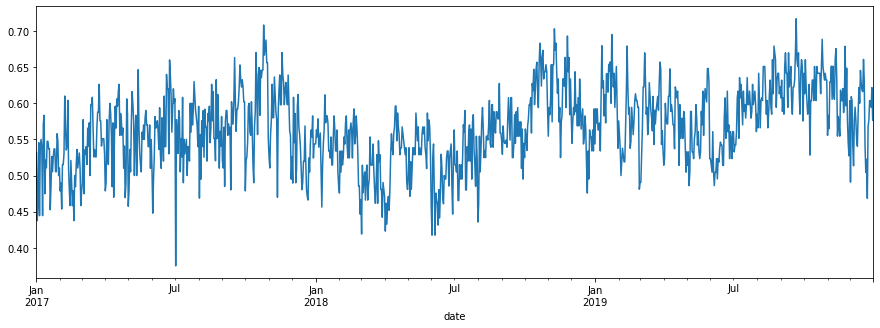

In [ ]:
df.groupby('date').full.mean().plot(figsize=(15,5))
#lower occupancy in summer

numpy.ndarray

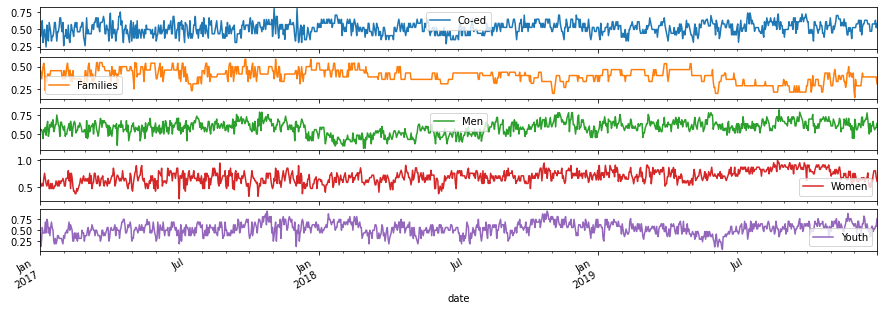

In [ ]:
axes = df.groupby(['date','sector']).full.mean().unstack().plot(figsize=(15,5),subplots=True)
type(axes)

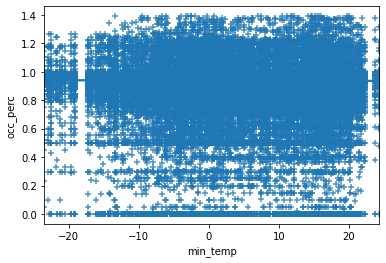

In [ ]:
#df.plot.scatter(x='min_temperature', y='occ_perc', c='DarkBlue')
sns.regplot(x='min_temp', y='occ_perc', data=df, marker="+")

In [ ]:
import plotly.express as px

df_map = df.groupby(['shelter','lat','long']).agg({'occ_perc': ['mean'],'full':['mean']})
# rename columns
df_map.columns = ['occ_perc_mean', 'full_mean']
# reset index to get grouped columns back
df_map = df_map.reset_index()

#px.scatter_geo(df_map, lat='lat', lon='long',size='full_mean', hover_name='shelter', text = 'occ_perc_mean', color='full_mean', color_continuous_scale = 'hot_r')

px.set_mapbox_access_token('pk.eyJ1Ijoiamdvb2R6OCIsImEiOiJja2hzanlhaGcwc25vMnhtam9rOTkyM3gxIn0.SGKwXjSu9-j0Mc5wUVJ9Qg')

fig = px.scatter_mapbox(df_map, lat="lat", lon="long", color="full_mean", size="full_mean", hover_name='shelter',
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)
fig.show()

Text(0.5, 1.05, 'Insurance Attributes Correlation Heatmap')

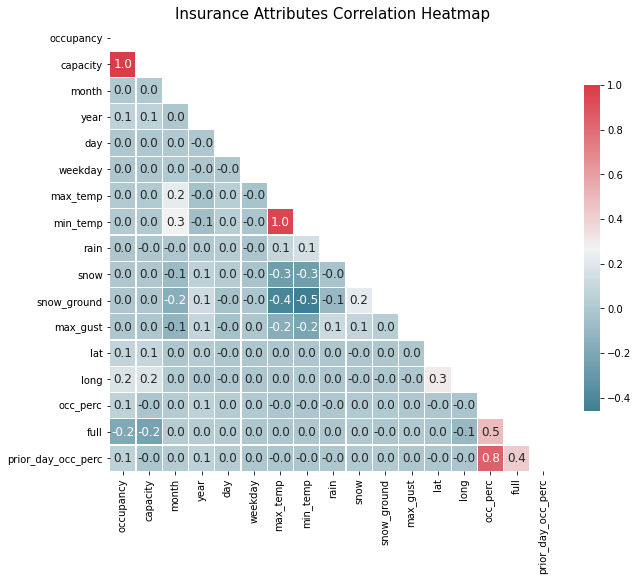

In [ ]:
#Look at correlation between variables
corr = df.corr()
    
_ , ax = plt.subplots(figsize =(10, 10))
colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
    
_ = sns.heatmap(round(corr,2), 
                cmap = colormap,
                square=True, 
                cbar_kws={'shrink':.6 }, 
                ax=ax,
                annot=True, 
                linewidths=0.1,vmax=1.0, linecolor='white',
                annot_kws={'fontsize':12 },
                fmt=".1f",
                mask=mask)
    
plt.title('Insurance Attributes Correlation Heatmap', y=1.05, size=15)

# most correlation is within weather and between weather and months, not interesting
# Prior day occupancy highly correlated to occupancy the next day. Shelters with less occupancy have slightly higher chance of being full  


# Pipeline

In [19]:
from sklearn.model_selection import train_test_split
#split train and test sets
train_set, test_set = train_test_split(df_ml, test_size=0.4, random_state=123)
#Consider sort by date and take first 2/3, shuffle = false

# Separate Exploratory (X) from target (y)
X_train = train_set.drop(['occ_perc','full'], axis=1) # drop label for training set
y_train = train_set['full'].copy()

X_test = test_set.drop(['occ_perc','full'], axis=1) # drop label for training set
y_test = test_set['full'].copy()


In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# prepare data pipeline
# numerical values scaled using standard scaler and built in median imputer just in case despite no null values observed
num_X = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_X = X_train.select_dtypes(include=['object', 'bool']).columns
#date_X = X_train.select_dtypes(include=['datetime64[ns]']).columns

# create pipeline
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),                 
        ('std_scaler', StandardScaler()),
    ])

preprocessor = ColumnTransformer([
        ("num", num_pipeline, num_X),
        ("cat", OneHotEncoder(), cat_X),
        #('date', SimpleImputer(), date_X)
    ])

X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.fit_transform(X_test)

In [ ]:
print(X_train_prepared.shape)
print(X_test_prepared.shape)

(67323, 150)
(44883, 150)


In [43]:
from sklearn.feature_extraction.text import _VectorizerMixin
from sklearn.feature_selection._base import SelectorMixin
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer

def get_feature_out(estimator, feature_in):
    if hasattr(estimator,'get_feature_names'):
        if isinstance(estimator, _VectorizerMixin):
            # handling all vectorizers
            return [f'vec_{f}' \
                for f in estimator.get_feature_names()]
        else:
            return estimator.get_feature_names(feature_in)
    elif isinstance(estimator, SelectorMixin):
        return np.array(feature_in)[estimator.get_support()]
    else:
        return feature_in


def get_ct_feature_names(ct):
    # handles all estimators, pipelines inside ColumnTransfomer
    # doesn't work when remainder =='passthrough'
    # which requires the input column names.
    output_features = []

    for name, estimator, features in ct.transformers_:
        if name!='remainder':
            if isinstance(estimator, Pipeline):
                current_features = features
                for step in estimator:
                    current_features = get_feature_out(step, current_features)
                features_out = current_features
            else:
                features_out = get_feature_out(estimator, features)
            output_features.extend(features_out)
        elif estimator=='passthrough':
            output_features.extend(ct._feature_names_in[features])
                
    return output_features

features = get_ct_feature_names(preprocessor)

In [ ]:
#could try PCA if more time

# ML Model Testing & Hyperparameter Tuning

In [37]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_auc_score, recall_score
from sklearn.model_selection import cross_val_predict 

def evaluate_model(y_actual, y_pred, y_score):
 
 auc = roc_auc_score(y_actual, y_score)
 accuracy = accuracy_score(y_actual, y_pred)
 recall = recall_score(y_actual, y_pred)
 precision = precision_score(y_actual, y_pred)
 f1 = f1_score(y_actual, y_pred)
 prevalence = np.mean(y_actual)
 y_pred_calc = y_pred
 print('AUC:%.3f'%auc)
 print('accuracy:%.3f'%accuracy)
 print('recall:%.3f'%recall)
 print('precision:%.3f'%precision)
 print('f1:%.3f'%f1)
 print('prevalence:%.3f'%prevalence)
 print('')

No Skill Prediction

In [49]:
# generate a no skill prediction (majority class)
ns_probs = [1 for _ in range(len(y_train))]

In [50]:
from sklearn.metrics import roc_curve
fpr_ns, tpr_ns, thresholds_ns = roc_curve(y_train,ns_probs)

Random-Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=123, oob_score=True)

In [ ]:
# fit untuned random forecast classifier
forest_clf.fit(X_train_prepared, y_train)
print(forest_clf.oob_score_)

0.8624541390015299


In [ ]:
#check fit on train set
from sklearn.metrics import accuracy_score
y_forest_pred = forest_clf.predict(X_train_prepared)
accuracy_score(y_train, y_forest_pred)
# overfitting

0.9999851462353133

In [ ]:
#time-series cross-validation accuracy pre tuning for reference
from sklearn.model_selection import cross_val_score
tscv = TimeSeriesSplit(n_splits=3)
cross_val_score(forest_clf, X_train_prepared, y_train, cv=tscv, scoring="accuracy")

array([0.86048723, 0.8620915 , 0.86256684])

In [22]:
#Time series based hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import uniform
from sklearn.ensemble import RandomForestClassifier

# Number of trees in random forest (default = 100)
n_estimators = [100, 500, 1000]
# Number of features to consider at every split (default = 'auto')
max_features = ['sqrt'] #, 'auto']
# Maximum number of levels in tree (default = None, unlimited)
max_depth = [100, None]
# Minimum number of samples required to split a node (default = 2)
min_samples_split = [2, 10]
# Minimum number of samples required at each leaf node (default = 1)
min_samples_leaf = [1, 5]
# Number of leaf nodes (default = None, unlimited )
max_leaf_nodes = [10, None]
# Method of selecting samples for training each tree
bootstrap = [True] #,False]

#Create timeseries cv 
tscv = TimeSeriesSplit(n_splits=3)

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(RandomForestClassifier(), param_distributions=random_grid, n_iter=15, cv=tscv, verbose=2, random_state=123, scoring='accuracy', n_jobs=1) #n_jobs=-1, pre_dispatch='2*n_jobs')
rf_random.fit(X_train_prepared, y_train)
print(rf_random.best_params_)
print(rf_random.best_score_)
forest_clf = rf_random.best_estimator_
#/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
#  "timeout or by a memory leak.", UserWarning <- error when using n_jobs = -1

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total= 1.3min
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total= 3.1min
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total= 5.3min
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=5, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=5, max_features=sqrt, max_depth=None, bootstrap=True, total=  58.8s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=5, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=5, max_features=sqrt, max_depth=None, bootstrap=True, total= 2.4min
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=5, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_esti

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 74.1min finished


{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': True}
0.8640720934838582


In [23]:
rf_random.cv_results_

{'mean_fit_time': array([189.46682779, 146.65725811,  14.81711761,  14.58408189,
         18.98693212, 147.39412244,  72.83233444, 146.13878775,
         94.90202181,  18.86259007, 145.94776217,  29.96010947,
         96.0967919 ,  14.83524307, 301.61476564]),
 'mean_score_time': array([3.90197778, 3.30828102, 0.33486462, 0.32818739, 0.39742565,
        3.32025409, 1.64320588, 3.29907982, 1.9484005 , 0.390402  ,
        3.27101668, 0.43854094, 2.04313318, 0.33404422, 4.58773907]),
 'mean_test_score': array([0.86407209, 0.86090315, 0.86092296, 0.86048723, 0.86391365,
        0.86044761, 0.86098237, 0.86086354, 0.8637552 , 0.86306199,
        0.86078431, 0.86022975, 0.86379481, 0.8600713 , 0.86161616]),
 'param_bootstrap': masked_array(data=[True, True, True, True, True, True, True, True, True,
                    True, True, True, True, True, True],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, F

In [46]:
#selected 5th run for best combination of accuracy and speed
forest_clf = RandomForestClassifier(random_state=123, max_features='sqrt', min_samples_split=10)
forest_clf.fit(X_train_prepared, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [38]:
#evaluate tuned model
from sklearn.model_selection import cross_val_predict

y_forest_pred = cross_val_predict(forest_clf, X_train_prepared, y_train, cv=3)
y_probas_forest = cross_val_predict(forest_clf, X_train_prepared, y_train, cv=3, method="predict_proba")
y_forest_scores = y_probas_forest[:, 1]
evaluate_model(y_train, y_forest_pred, y_forest_scores)

AUC:0.935
accuracy:0.865
recall:0.913
precision:0.857
f1:0.884
prevalence:0.566



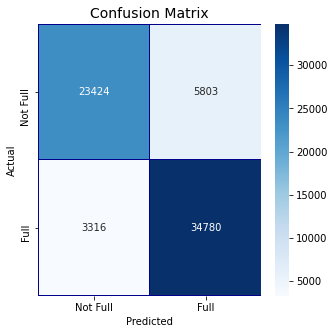

In [39]:
cm = pd.crosstab(y_train, y_forest_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Full', 'Full'],
            yticklabels=['Not Full', 'Full'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt='g')
plt.title('Confusion Matrix', fontsize=14)
plt.show()

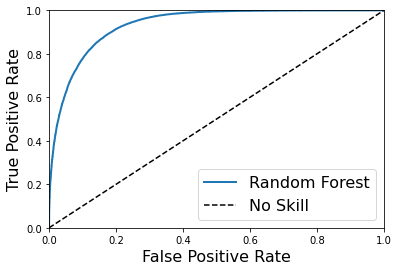

In [73]:
from sklearn.metrics import roc_curve

#for random forest
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_forest_scores)

#for no skill
fpr_ns, tpr_ns, thresholds_ns = roc_curve(y_train, ns_probs)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    #plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
#Plot the Roc Curve
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr_ns, tpr_ns, 'k--', label="No Skill")
plt.legend(loc="lower right", fontsize=16)
plt.show()

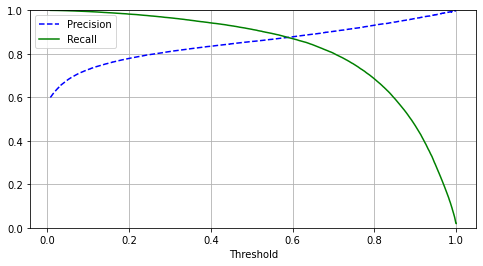

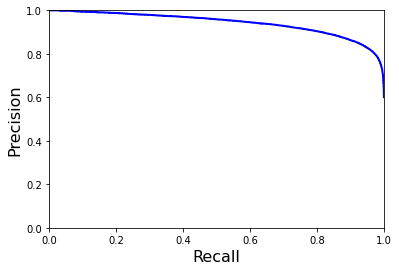

In [41]:
#create threshold and precision - recall curve
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train,y_forest_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="best")
    plt.ylim([0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.show()

#plot the precision and recall curve

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

    
plot_precision_vs_recall(precisions, recalls)
plt.show()
#If city is low on resources, could consider increase to 0.6 to improve precision (how often we are correct, minimize risk of creating new capacity for no reason) but as some cost to recall (missing opening extra capacity when needed)
#If city has some additional capacity, could consider lowering threshold to 0.2 which would catch almost all times the shelters are full while still keeping about 80% precision (i.e. very low chance of not having shelter for someone that needs it but opening up extra capacity about 20% of the time instead of 14% with current threshold)

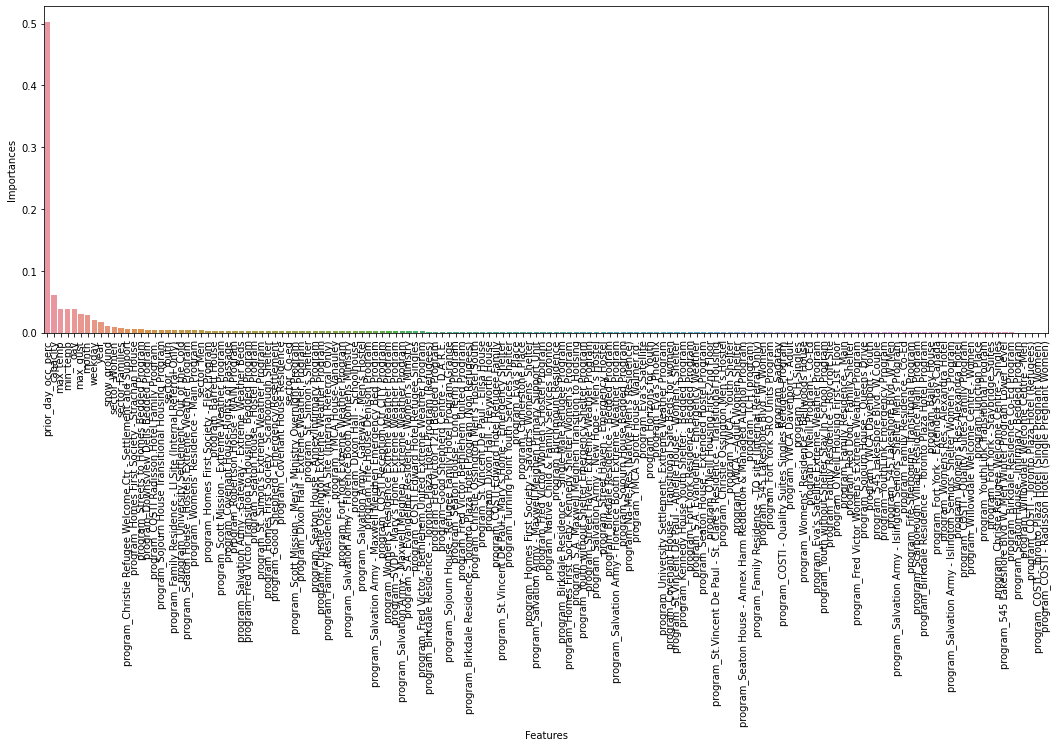

,Features,Importances
9,prior_day_occ_perc,0.502674
0,capacity,0.061128
5,max_temp,0.038192
6,min_temp,0.037955
3,day,0.037860
...,...,...
108,program_Seaton House - Infirmary Bedded Program,0.000075
128,program_Willowdale Welcome Centre - Men,0.000046
26,program_COSTI - Toronto Plaza Hotel (Refugees),0.000011
27,program_COSTI - Toronto Plaza Hotel (Single Pr...,0.000011


In [47]:
#Look at feature importances (need to get columns from df)

def feature_importances(clf, X, figsize=(18, 6)):
    importances = pd.DataFrame({'Features': features, 
                                'Importances': clf.feature_importances_})
    
    importances.sort_values(by=['Importances'], axis='index', ascending=False, inplace=True)

    fig = plt.figure(figsize=figsize)
    sns.barplot(x='Features', y='Importances', data=importances)
    plt.xticks(rotation='vertical')
    plt.show()
    return importances

feature_importances(forest_clf, X_train_prepared) 

SVM Classifer

KNN Classifier

In [85]:
# fit untuned random forecast classifier
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_prepared, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [86]:
#check fit on train set
from sklearn.metrics import accuracy_score
y_knn_pred = Knn_clf.predict(X_train_prepared)
accuracy_score(y_train, y_knn_pred)

0.8762384326307503

In [93]:
#time-series cross-validation accuracy pre tuning for reference
from sklearn.model_selection import cross_val_score
tscv = TimeSeriesSplit(n_splits=3)
cross_val_score(knn_clf, X_train_prepared, y_train, cv=tscv, scoring="accuracy")

array([0.78514557, 0.80386215, 0.8130719 ])

In [90]:
#Time series based hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import uniform
from sklearn.neighbors import KNeighborsClassifier

# Number of neighbors (default = 5)
n_neighbors = [5,8,10]
# Leaf size passed to BallTree or KDTree. This can affect the speed of the construction and query, as well as the memory required to store the tree. The optimal value depends on the nature of the problem (default = 30)
leaf_size = [1,10,30,40]
# weight function used in prediction (default = uniform)
weights = ['uniform', 'distance']
# Algorithm used to compute the nearest neighbors (default = auto, attempts to decide most appropriate)
algorithm = ['auto', 'ball_tree','kd_tree','brute']
#Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2
p = [1,2]
# Minimum number of samples required at each leaf node (default = 1)
n_jobs = [-1]

#Create timeseries cv 
tscv = TimeSeriesSplit(n_splits=3)

# Create the random grid
random_grid = {'n_neighbors':n_neighbors,
          'leaf_size':leaf_size,
          'weights': weights,
          'algorithm':algorithm,
          'p': p,
          'n_jobs':n_jobs}

knn_random = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=random_grid, n_iter=20, cv=tscv, verbose=2, random_state=123, scoring='accuracy', n_jobs=1) #n_jobs=-1, pre_dispatch='2*n_jobs')
knn_random.fit(X_train_prepared, y_train)
print(knn_random.best_params_)
print(knn_random.best_score_)
knn_clf = knn_random.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] weights=uniform, p=1, n_neighbors=8, n_jobs=-1, leaf_size=30, algorithm=brute 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  weights=uniform, p=1, n_neighbors=8, n_jobs=-1, leaf_size=30, algorithm=brute, total=  32.8s
[CV] weights=uniform, p=1, n_neighbors=8, n_jobs=-1, leaf_size=30, algorithm=brute 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.8s remaining:    0.0s


[CV]  weights=uniform, p=1, n_neighbors=8, n_jobs=-1, leaf_size=30, algorithm=brute, total= 1.3min
[CV] weights=uniform, p=1, n_neighbors=8, n_jobs=-1, leaf_size=30, algorithm=brute 
[CV]  weights=uniform, p=1, n_neighbors=8, n_jobs=-1, leaf_size=30, algorithm=brute, total= 1.9min
[CV] weights=uniform, p=2, n_neighbors=5, n_jobs=-1, leaf_size=30, algorithm=auto 
[CV]  weights=uniform, p=2, n_neighbors=5, n_jobs=-1, leaf_size=30, algorithm=auto, total=  45.1s
[CV] weights=uniform, p=2, n_neighbors=5, n_jobs=-1, leaf_size=30, algorithm=auto 
[CV]  weights=uniform, p=2, n_neighbors=5, n_jobs=-1, leaf_size=30, algorithm=auto, total= 1.0min
[CV] weights=uniform, p=2, n_neighbors=5, n_jobs=-1, leaf_size=30, algorithm=auto 
[CV]  weights=uniform, p=2, n_neighbors=5, n_jobs=-1, leaf_size=30, algorithm=auto, total= 1.3min
[CV] weights=distance, p=1, n_neighbors=8, n_jobs=-1, leaf_size=40, algorithm=auto 
[CV]  weights=distance, p=1, n_neighbors=8, n_jobs=-1, leaf_size=40, algorithm=auto, total=

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 73.8min finished


NameError: ignored

In [91]:
knn_random.cv_results_

{'mean_fit_time': array([0.03330493, 2.5460511 , 2.56806016, 3.00598224, 2.41113091,
        2.51027425, 2.348761  , 0.02699526, 2.48257343, 2.49685152,
        2.95386195, 0.02875566, 0.02913721, 2.77206341, 2.53670684,
        0.0286351 , 2.7518905 , 2.38855124, 0.02853147, 0.0276773 ]),
 'mean_score_time': array([ 74.78474347,  58.30168192,  87.01352286, 131.06824875,
        114.17802278,  69.26898122, 103.61064585,  26.06123845,
         38.27314838, 126.92865841,  71.36040489,  25.7535104 ,
         25.34630545,  67.69864798, 110.47973466,  70.29943673,
         82.71492235, 109.42959023,  25.23459737,  25.14873171]),
 'mean_test_score': array([0.79578134, 0.7929689 , 0.80013864, 0.7956427 , 0.79063181,
        0.79427609, 0.79302832, 0.7929689 , 0.80013864, 0.79560309,
        0.80027728, 0.79134482, 0.79455338, 0.79120618, 0.79465241,
        0.79578134, 0.7956427 , 0.80017825, 0.80069321, 0.80031689]),
 'param_algorithm': masked_array(data=['brute', 'auto', 'auto', 'auto', 'ba

In [98]:
print(knn_random.best_params_)
print(knn_random.best_score_)
knn_clf = knn_random.best_estimator_
#about the same accuracy but faster

{'weights': 'distance', 'p': 2, 'n_neighbors': 10, 'n_jobs': -1, 'leaf_size': 1, 'algorithm': 'brute'}
0.8006932065755595


In [99]:
#knn_clf = KNeighborsClassifier(n_neighbors=10, algorithm='brute', weights='distance')
knn_clf.fit(X_train_prepared, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
                     weights='distance')

In [100]:
#evaluate tuned model
from sklearn.model_selection import cross_val_predict

y_knn_pred = cross_val_predict(knn_clf, X_train_prepared, y_train, cv=3)
y_probas_knn = cross_val_predict(knn_clf, X_train_prepared, y_train, cv=3, method="predict_proba")
y_knn_scores = y_probas_knn[:, 1]
evaluate_model(y_train, y_knn_pred, y_knn_scores)

AUC:0.881
accuracy:0.809
recall:0.901
precision:0.791
f1:0.843
prevalence:0.566



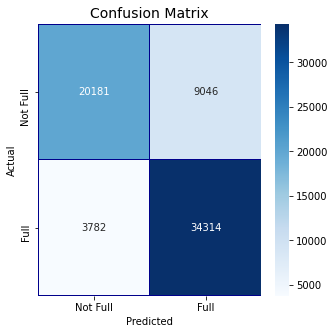

In [101]:
cm = pd.crosstab(y_train, y_knn_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Full', 'Full'],
            yticklabels=['Not Full', 'Full'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt='g')
plt.title('Confusion Matrix', fontsize=14)
plt.show()

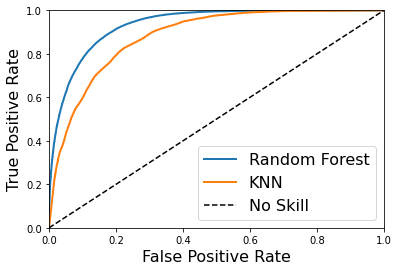

In [104]:
from sklearn.metrics import roc_curve

#for random forest
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_forest_scores)

#for KNN
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train, y_knn_scores)

#for no skill
fpr_ns, tpr_ns, thresholds_ns = roc_curve(y_train, ns_probs)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    #plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
#Plot the Roc Curve
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plot_roc_curve(fpr_knn, tpr_knn, "KNN")
plt.plot(fpr_ns, tpr_ns, 'k--', label="No Skill")
plt.legend(loc="lower right", fontsize=16)
plt.show()

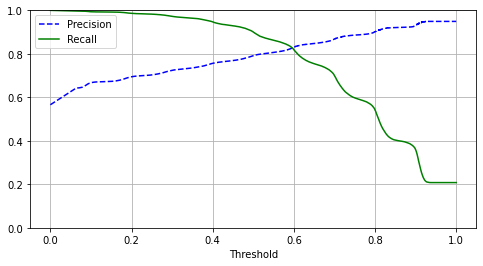

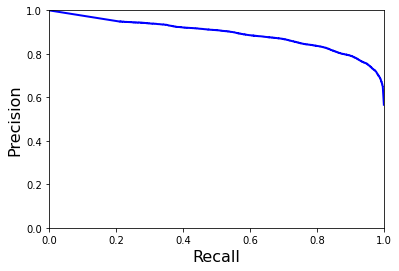

In [105]:
#create threshold and precision - recall curve
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train,y_knn_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="best")
    plt.ylim([0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.show()

#plot the precision and recall curve

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

    
plot_precision_vs_recall(precisions, recalls)
plt.show()
#If city is low on resources, could consider increase to 0.6 to improve precision (how often we are correct, minimize risk of creating new capacity for no reason) but as some cost to recall (missing opening extra capacity when needed)
#If city has some additional capacity, could consider lowering threshold to 0.2 which would catch almost all times the shelters are full while still keeping about 80% precision (i.e. very low chance of not having shelter for someone that needs it but opening up extra capacity about 20% of the time instead of 14% with current threshold)

SGC Log Classifier

array([0.85801437, 0.00439394, 0.84419967, ..., 0.57011064, 0.70140211,
       0.91434402])

Decision Tree Classifier

Naive Bayes Classifier

In [75]:
#Fit NB model
from sklearn.naive_bayes import GaussianNB
NB_clf = GaussianNB()
NB_clf.fit(X_train_prepared, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [76]:
#evaluate NB model
from sklearn.model_selection import cross_val_predict

y_NB_pred = cross_val_predict(NB_clf, X_train_prepared, y_train, cv=3)
y_probas_NB = cross_val_predict(NB_clf, X_train_prepared, y_train, cv=3, method="predict_proba")
y_NB_scores = y_probas_NB[:, 1]
evaluate_model(y_train, y_NB_pred, y_NB_scores)

AUC:0.813
accuracy:0.783
recall:0.880
precision:0.769
f1:0.821
prevalence:0.566



In [80]:
#time-series cross-validation accuracy
from sklearn.model_selection import cross_val_score
tscv = TimeSeriesSplit(n_splits=3)
cross_val_score(NB_clf, X_train_prepared, y_train, cv=tscv, scoring="accuracy")

array([0.77736185, 0.77843137, 0.77843137])

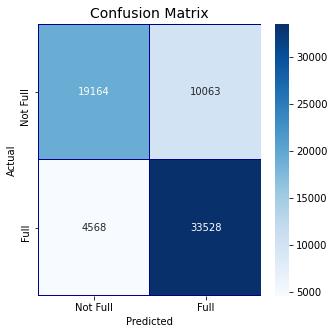

In [81]:
cm = pd.crosstab(y_train, y_NB_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Full', 'Full'],
            yticklabels=['Not Full', 'Full'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt='g')
plt.title('Confusion Matrix', fontsize=14)
plt.show()

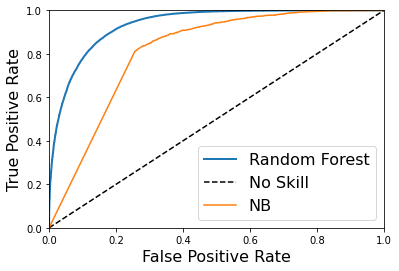

In [83]:
from sklearn.metrics import roc_curve

#for random forest
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_forest_scores)

#for no skill
fpr_ns, tpr_ns, thresholds_ns = roc_curve(y_train, ns_probs)

#for NB
fpr_NB, tpr_NB, thresholds_NB = roc_curve(y_train, y_NB_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    #plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
#Plot the Roc Curve
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr_ns, tpr_ns, 'k--', label="No Skill")
plt.plot(fpr_NB, tpr_NB, label="NB")
plt.legend(loc="lower right", fontsize=16)
plt.show()

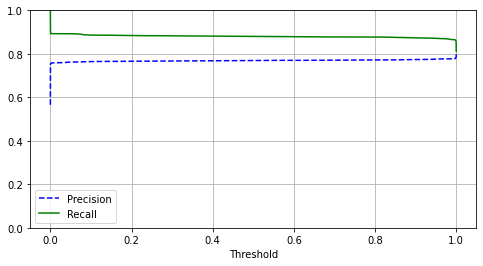

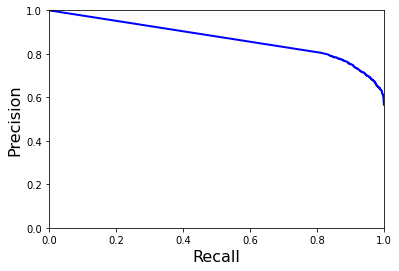

In [84]:
#create threshold and precision - recall curve
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_NB_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="best")
    plt.ylim([0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.show()

#plot the precision and recall curve

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

    
plot_precision_vs_recall(precisions, recalls)
plt.show()

Bagging

Boosting

Stacking

Final Model Comparison

In [ ]:
#Plot all ROC curves, compare key metrics in single table

In [ ]:
df_results = train_set.copy()
df_results['rf_pred'] = y_forest_pred
df_results['knn_pred'] = y_knn_pred
df_results['NB_pred'] = y_knn_pred

# Final Model Evaluation

Decision Tree Classifier

In [ ]:
#Notes: removing some features had limited impact on accuracy, hyperparameter accuracy vs time, balanced, cleaning

In [ ]:
#TA questions: should train/test be time based? mostly unique programs to facility and shelter, can I streamline to avoid so many features (PCA)? 

# PCA Test - Loss in accuracy didn't seem to make up for gains in speed

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# prepare data pipeline
# numerical values scaled using standard scaler and built in median imputer just in case despite no null values observed
num_X = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_X = X_train.select_dtypes(include=['object', 'bool']).columns
#date_X = X_train.select_dtypes(include=['datetime64[ns]']).columns

# create pipeline
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),                 
        ('std_scaler', StandardScaler()),
    ])

preprocessor = ColumnTransformer([
        ("num", num_pipeline, num_X),
        ("cat", OneHotEncoder(sparse=False), cat_X),
        #('date', SimpleImputer(), date_X)
    ])

X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.fit_transform(X_test)

In [35]:
#Look at elbow method to see where gains in unexplained variance start to dimish, i.e. a good place to cut-off
from sklearn.decomposition import PCA
import plotly.express as px

pca = PCA(random_state=123).fit(X_train_prepared)
#plt.plot(np.cumsum(pca.explained_variance_ratio_))
#plt.xlabel('number of components')
#plt.ylabel('cumulative explained variance')

exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
px.line(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Cumulative Explained Variance"}
)

In [29]:
#can set explained variance target, e.g. 90% 
pca = PCA(n_components=0.9, random_state=123).fit(X_train_prepared)
pca.n_components_

12

In [31]:
#fit PCA on X_train
X_train_pca = pca.transform(X_train_prepared)

In [36]:
#evaluate model with PCA dim reduction, note accuracy is ~3% lower, speed was not noticeably improved
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict 
y_forest_pred = cross_val_predict(RandomForestClassifier(random_state=123), X_train_pca, y_train, cv=3)
y_probas_forest = cross_val_predict(RandomForestClassifier(random_state=123), X_train_pca, y_train, cv=3, method="predict_proba")
y_forest_scores = y_probas_forest[:, 1]
evaluate_model(y_train, y_forest_pred, y_forest_scores)

AUC:0.902
accuracy:0.834
recall:0.866
precision:0.844
f1:0.855
prevalence:0.566



In [26]:
# example to evaluate PCA hyperparameters, data was too large for kernel PCA it seems, would need to try another strategy (batch?)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import KernelPCA, PCA

pipe = Pipeline([
        #('kpca', KernelPCA()), #kpca kept crashing, not enough RAM?
        ('pca', PCA()),
        ('rf', RandomForestClassifier(max_features='sqrt', min_samples_leaf=5 ,random_state=123))
    ])

param_grid = [{
        'pca__n_components': [5, 10, 20]
        #'kpca__n_components': [10, 20],
        #'kpca__gamma': [0.01, 0.05], #np.linspace(0.03, 0.05, 10),
        #'kpca__kernel': ['linear', 'rbf', 'sigmoid']
    }]

estimator = RandomizedSearchCV(pipe, param_distributions=param_grid, verbose=2, n_iter=1, n_jobs=-1, pre_dispatch='2*n_jobs', cv=3)
estimator.fit(X_train_prepared, y_train)

print("The best parameters: {0}".format(estimator.best_params_))
print("The best score: {0}".format(estimator.best_score_))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   45.8s finished


The best parameters: {'pca__n_components': 10}


In [27]:
print("The best score: {0}".format(estimator.best_score_))

The best score: 0.8206259376438959


In [ ]:
#pipe.set_params(**estimator.best_params_)